In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import helper_functions as hf
from pathlib import Path

In [2]:
root_dir = Path("Data")

tickers = ["CRWV", "FROG", "SOUN"]

ticker_lob_snapshots = {
    ticker: hf.get_lob_snapshots(root_dir / ticker)
    for ticker in tickers
}

In [3]:
display(ticker_lob_snapshots["CRWV"].head())
display(ticker_lob_snapshots["FROG"].head())
display(ticker_lob_snapshots["SOUN"].head())

,ts_event,mid_px,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_px_01,ask_px_01,bid_sz_01,ask_sz_01,...,bid_sz_07,ask_sz_07,bid_px_08,ask_px_08,bid_sz_08,ask_sz_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09
0,2025-04-03 13:30:00,55.250,55.10,55.40,1.0,199.0,55.06,55.46,1667.0,10.0,...,1.0,5.0,54.57,56.66,400.0,4.0,54.55,56.70,100.0,10.0
1,2025-04-03 13:31:00,54.580,54.50,54.66,726.0,5.0,54.49,54.70,8.0,570.0,...,1.0,20.0,54.30,55.20,205.0,200.0,54.25,55.23,118.0,10.0
2,2025-04-03 13:32:00,53.400,53.24,53.56,29.0,200.0,53.23,53.97,18.0,100.0,...,200.0,2165.0,53.02,55.05,50.0,940.0,53.01,55.17,710.0,20.0
3,2025-04-03 13:33:00,53.460,53.40,53.52,105.0,385.0,53.37,53.75,1000.0,100.0,...,51.0,1005.0,53.20,55.00,620.0,15.0,53.18,55.17,1000.0,20.0
4,2025-04-03 13:34:00,54.575,54.57,54.58,20.0,2100.0,54.55,54.71,100.0,100.0,...,100.0,1410.0,54.24,55.30,5400.0,85.0,54.20,55.35,370.0,4.0


,ts_event,mid_px,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_px_01,ask_px_01,bid_sz_01,ask_sz_01,...,bid_sz_07,ask_sz_07,bid_px_08,ask_px_08,bid_sz_08,ask_sz_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09
0,2025-04-03 13:30:00,31.050,30.10,32.00,50.0,200.0,30.00,32.64,147.0,100.0,...,100.0,800.0,28.96,33.85,800.0,4.0,28.49,33.92,100.0,100.0
1,2025-04-03 13:31:00,31.285,31.07,31.50,300.0,225.0,31.01,31.54,100.0,5.0,...,200.0,100.0,30.60,32.13,20.0,200.0,30.48,32.27,10.0,100.0
2,2025-04-03 13:32:00,31.640,31.41,31.87,500.0,220.0,31.15,31.99,200.0,100.0,...,100.0,130.0,30.86,32.51,100.0,100.0,30.83,32.65,104.0,100.0
3,2025-04-03 13:33:00,31.640,31.41,31.87,500.0,220.0,31.15,31.99,200.0,100.0,...,100.0,800.0,30.86,32.50,100.0,130.0,30.83,32.51,104.0,100.0
4,2025-04-03 13:34:00,31.640,31.41,31.87,400.0,223.0,31.24,31.99,200.0,100.0,...,100.0,130.0,30.86,32.51,100.0,100.0,30.83,32.65,104.0,100.0


,ts_event,mid_px,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_px_01,ask_px_01,bid_sz_01,ask_sz_01,...,bid_sz_07,ask_sz_07,bid_px_08,ask_px_08,bid_sz_08,ask_sz_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09
0,2025-04-03 13:30:00,7.900,7.89,7.91,112,164,7.88,7.92,132,4,...,67,50,7.80,8.03,6690,84,7.79,8.07,15,29
1,2025-04-03 13:31:00,8.085,8.07,8.10,1050,1844,8.06,8.11,2200,3188,...,673,51,7.99,8.18,655,179,7.98,8.19,556,54
2,2025-04-03 13:32:00,8.165,8.16,8.17,1300,100,8.15,8.18,3892,400,...,550,251,8.08,8.25,550,215,8.07,8.26,350,279
3,2025-04-03 13:33:00,8.145,8.13,8.16,1400,1079,8.12,8.17,2820,3524,...,568,404,8.05,8.24,250,251,8.04,8.25,115,215
4,2025-04-03 13:34:00,8.220,8.21,8.23,300,660,8.20,8.24,4665,2451,...,529,421,8.13,8.31,901,6648,8.12,8.32,660,3050


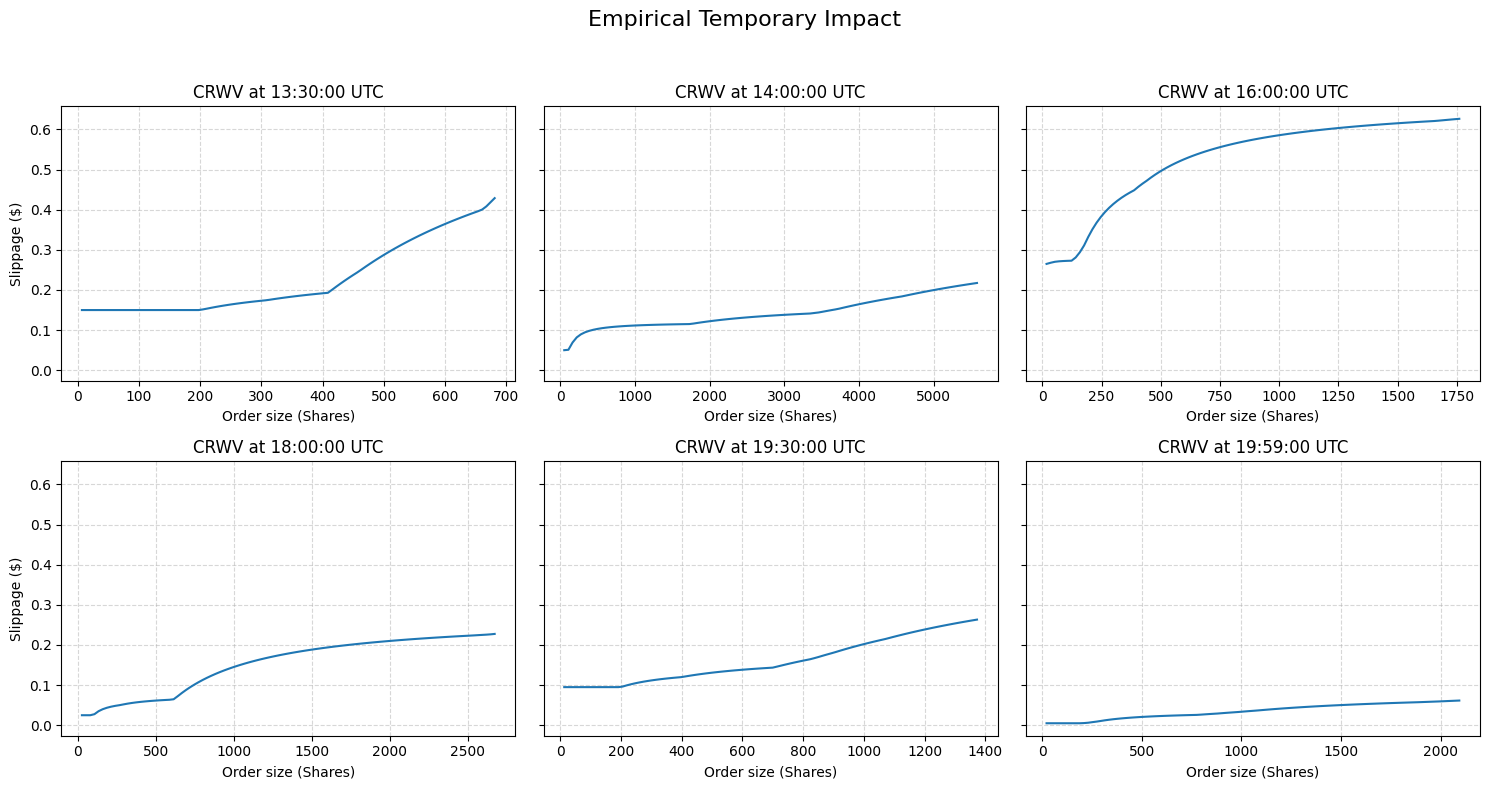

In [11]:
times_to_sample = ["13:30:00", "14:00:00", "16:00:00", "18:00:00", "19:30:00", "19:59:00"]
df = ticker_lob_snapshots["CRWV"]

fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=True)

for ax, t in zip(axs.flat, times_to_sample):
    snapshot = df[df['ts_event'].dt.strftime('%H:%M:%S') == t].iloc[0]
    x_vals, g_vals = hf.compute_empirical_impact(snapshot, side='buy')
    ax.plot(x_vals, g_vals, label='Buy-side impact')
    ax.set_title(f"CRWV at {t} UTC")
    ax.set_xlabel("Order size (Shares)")
    ax.grid(True, linestyle='--', alpha=0.5)

axs[0, 0].set_ylabel("Slippage ($)")
axs[1, 0].set_ylabel("Slippage ($)")
fig.suptitle("Empirical Temporary Impact", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()